In [1]:
import numpy as np

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import stats
from astropy.modeling.models import Gaussian2D, Lorentz2D, Moffat2D
from astropy.modeling import fitting

from photutils.aperture import CircularAperture

from mmtwfs.wfs import check_wfsdata, wfsfind

In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [63]:
bino_file = "/Volumes/Elements_18TB/wfsdat/20241001/wfs_ff_cal_img_2024.10.01T025918.888.fits"
bino_file = "~/MMT/wfsdat/20250203/wfs_ff_cal_img_2025.02.03T090019.611.fits"
data = check_wfsdata(bino_file)

In [64]:
mean, median, stddev = stats.sigma_clipped_stats(data, sigma=3.0, maxiters=None)

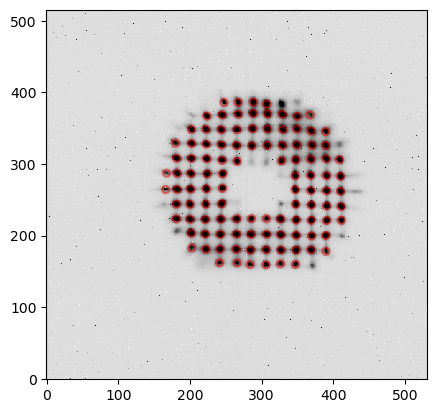

In [65]:
srcs, wfsfind_fig = wfsfind(data, fwhm=7., threshold=5., std=stddev, plot=True)

In [66]:
apers = CircularAperture(
    list(zip(srcs['xcentroid'], srcs['ycentroid'])),
    r=15.
)

In [67]:
masks = apers.to_mask(method='subpixel')
sigma = 0.0
snrs = []
spot = np.zeros(masks[0].shape)
for m in masks:
    subim = m.cutout(data)

    # make co-added spot image for use in calculating the seeing
    if subim.shape == spot.shape:
        spot += subim

    signal = subim.sum()
    noise = np.sqrt(stddev**2 * subim.shape[0] * subim.shape[1])
    snr = signal / noise
    snrs.append(snr)

snrs = np.array(snrs)
fits.writeto("spot.fits", spot, overwrite=True)

back = np.mean([spot[:2, :].mean(), spot[-2:, :].mean(), spot[:, :2].mean(), spot[:, -2:].mean()])
print(back)
spot -= back
g2d = Gaussian2D(amplitude=spot.max(), x_mean=spot.shape[1]/2, y_mean=spot.shape[0]/2)
l2d = Lorentz2D(amplitude=spot.max(), x_0=spot.shape[1]/2, y_0=spot.shape[0]/2)
m2d = Moffat2D(amplitude=spot.max(), x_0=spot.shape[1]/2, y_0=spot.shape[0]/2)

model = m2d
gmodel = g2d
fitter = fitting.DogBoxLSQFitter()
y, x = np.mgrid[:spot.shape[0], :spot.shape[1]]
fit = fitter(model, x, y, spot)
gfit = fitter(gmodel, x, y, spot)

gsigma = 0.5 * (gfit.x_stddev.value + gfit.y_stddev.value)
#print(sigma)
print(fit.fwhm, gsigma * stats.gaussian_sigma_to_fwhm)

63695.87096774194
5.939688049715244 6.281379911842996


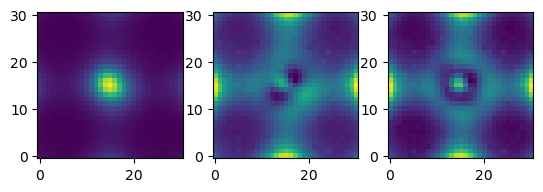

In [68]:
fig, ax = plt.subplots(1, 3)
im1 = ax[0].imshow(spot, origin='lower')
im2 = ax[1].imshow(spot - fit(x, y), origin='lower')
im2 = ax[2].imshow(spot - gfit(x, y), origin='lower')
plt.show()

In [102]:
plt.close('all')

In [110]:
stats.gaussian_fwhm_to_sigma * fit.fwhm

np.float64(3.5566673390642554)